In [1]:
import sys
!{sys.executable} -m pip install deap

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from deap import base, creator, tools, algorithms
import random

# Load dataset (using the JM1 dataset as an example)
data = pd.read_csv('./cm1.csv')

# Drop any missing values
data = data.dropna()

# Separate features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [3]:
# There is no built in package for ACO, here is the implementation:
class ACO:
    def __init__(self, n_features, n_ants, n_iterations, evaporation_rate, alpha, beta, seed=None):
        self.n_features = n_features
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.pheromone = np.ones(n_features) / n_features
        if seed:
            random.seed(seed)
            np.random.seed(seed)

    def _select_features(self, feature_prob):
        features = []
        for i, prob in enumerate(feature_prob):
            if random.random() < prob:
                features.append(i)
        return features

    def optimize(self, fitness_function):
        best_fitness = -1
        best_features = None

        for iteration in range(self.n_iterations):
            solutions = []
            fitnesses = []

            for ant in range(self.n_ants):
                feature_prob = self.pheromone**self.alpha * ((1.0 / self.pheromone)**self.beta)
                feature_prob /= np.sum(feature_prob)
                selected_features = self._select_features(feature_prob)
                fitness = fitness_function(selected_features)

                if fitness > best_fitness:
                    best_fitness = fitness
                    best_features = selected_features

                solutions.append(selected_features)
                fitnesses.append(fitness)

            for i, solution in enumerate(solutions):
                for feature in solution:
                    self.pheromone[feature] += fitnesses[i]

            self.pheromone *= (1 - self.evaporation_rate)

        return best_features


In [4]:
def evalFeatureSelection(selected_features):
    if len(selected_features) == 0:
        return 0

    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    clf = GaussianNB()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

In [5]:
# Select features with ACO:
n_features = X_train.shape[1]
n_ants = 30
n_iterations = 20

aco = ACO(n_features, n_ants, n_iterations, evaporation_rate=0.1, alpha=1, beta=1, seed=42)
selected_features = aco.optimize(evalFeatureSelection)

In [6]:
print("Number of selected features: ", len(selected_features))

Number of selected features:  1


In [7]:
# Train the classifier
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = GaussianNB()
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.8933333333333333
              precision    recall  f1-score   support

       False       0.89      1.00      0.94       134
        True       0.00      0.00      0.00        16

    accuracy                           0.89       150
   macro avg       0.45      0.50      0.47       150
weighted avg       0.80      0.89      0.84       150



/Users/benardcharumbira/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benardcharumbira/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benardcharumbira/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

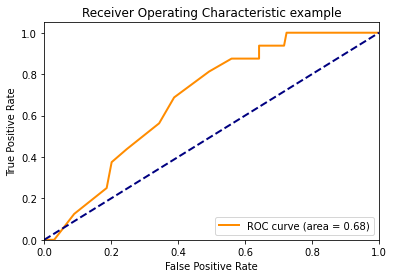

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'AUC': roc_auc
})
df.to_csv('./AUC_Extracts/CM1/CM1_NB_ACO.csv', index=False)

# Plot
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic example')
plt.legend(loc="lower right")
plt.show()